In [15]:
import torch, matplotlib.pyplot as plt, numpy as np
from ipypb import track as tqdm
import diffplan, astar, envs, prior_envs, search
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import random
random.seed(0)
print(search.bfs(prior_envs.f2c, 0, 5))
random.seed(1)
print(search.bfs(prior_envs.f2c, 0, 5))

{'visited': {0, 1, 2, 3, 4}, 'frontier': set(), 'path': (None, [0, 1, 4, 5])}
{'visited': {0, 1, 2, 3, 4}, 'frontier': set(), 'path': (None, [0, 3, 4, 5])}


In [127]:
'''
First checking to see if keeping visited makes sense...
Preliminary, I'd say yeah! things like 1>4>8 are examples where it does
'''


def _doprint(msg, results_fn):
    ntimes = 500
    visiteds = np.zeros(ntimes)
    stepss = np.zeros(ntimes)
    for idx in range(ntimes):
        visited = 0.
        steps = 0.
        for res in results_fn():
            visited += len(res['visited'])
            steps += len(res['path'][1])-1
        visiteds[idx] = visited
        stepss[idx] = steps
    pstat = lambda ns: '{:.2f} +- {:.3f}'.format(np.mean(ns), np.std(ns)/ntimes**0.5)
    print(msg, 'visited', pstat(visiteds), 'steps', pstat(stepss), 'cost', np.mean(visiteds+stepss))

def dotest(s, sg, g):
    print(s, sg, g)
    _doprint('normal', lambda: [search.bfs(prior_envs.f2c, s, g)])
    _doprint('subgoals', lambda: [search.bfs(prior_envs.f2c, s, sg), search.bfs(prior_envs.f2c, sg, g)])

    def x():
        res = search.bfs(prior_envs.f2c, s, sg)
        res2 = search.bfs(prior_envs.f2c, sg, g, visited_init=res['visited'])
        res2['visited'] -= res['visited']
        return [res, res2]
    _doprint('sg_transfer', x)
    print()

dotest(0, 4, 8)
dotest(0, 5, 8)

dotest(8, 4, 0)
dotest(8, 5, 0)

dotest(1, 4, 8)
dotest(1, 5, 8)

dotest(1, 4, 9)
dotest(1, 5, 9)

0 4 8
normal visited 6.50 +- 0.022 steps 4.00 +- 0.000 cost 10.5
subgoals visited 9.83 +- 0.047 steps 4.00 +- 0.000 cost 13.826
sg_transfer visited 6.48 +- 0.022 steps 4.00 +- 0.000 cost 10.478

0 5 8
normal visited 6.51 +- 0.022 steps 4.00 +- 0.000 cost 10.51
subgoals visited 7.01 +- 0.037 steps 4.00 +- 0.000 cost 11.006
sg_transfer visited 6.51 +- 0.022 steps 4.00 +- 0.000 cost 10.512

8 4 0
normal visited 8.50 +- 0.022 steps 4.00 +- 0.000 cost 12.502
subgoals visited 9.92 +- 0.050 steps 4.00 +- 0.000 cost 13.924
sg_transfer visited 8.31 +- 0.029 steps 4.00 +- 0.000 cost 12.308

8 5 0
normal visited 8.48 +- 0.022 steps 4.00 +- 0.000 cost 12.484
subgoals visited 10.51 +- 0.043 steps 4.00 +- 0.000 cost 14.51
sg_transfer visited 8.48 +- 0.022 steps 4.00 +- 0.000 cost 12.476

1 4 8
normal visited 6.53 +- 0.022 steps 3.00 +- 0.000 cost 9.532
subgoals visited 7.88 +- 0.059 steps 3.00 +- 0.000 cost 10.88
sg_transfer visited 6.02 +- 0.041 steps 3.00 +- 0.000 cost 9.024

1 5 8
normal visited 

In [ ]:
# Next to do is: Make a variant of the environent where the state includes the search history. this should work to pass through BFS which 

In [514]:
class EnvWithSubgoalsAndVisited(object):
    def __init__(self, env, subgoals, search, *, include_actions=False, visited_in_state=True):
        '''
        An environment modeling a semi-MDP with deterministic subgoals.

        Must supply list of subgoals and the costs for navigating to those
        subgoals from other states. Costs must a quantity to minimize.
        '''
        self.env = env
        self.subgoals = subgoals
        self.search = search
        self.include_actions = include_actions
        self.visited_in_state = visited_in_state
        # ??????? self.states = env.states

        actions = []
        if self.include_actions:
            actions = list(env.actions)
        actions += [('sg', idx) for idx in range(len(subgoals))]
        self.actions = actions

    def step(self, state, a):
        si, visited = state
        if isinstance(a, tuple) and a[0] == 'sg': # HACK HACK HACK
            subgoal = self.subgoals[a[1]]
            res = self.search(self.env, si, subgoal, visited_init=visited)
            if res is None:
                return (si, visited), -float('inf'), None
            cost = (
                # Cost is new states this search process adds, so set difference from initial list of visited
                len(res['visited'] - visited) +
                # Along with number of actions needed to reach subgoal
                len(res['path'])-1
            )
            v = res['visited'] if self.visited_in_state else frozenset()
            return (subgoal, v), -cost, None
        else:
            assert False
            assert self.include_actions
            return self.env.step(si, a)


In [518]:
random.seed(30) # includes 4 in the final path
env = prior_envs.f2c
start, goal = 1, 8

import time; st = time.time()
for _ in range(1000):
    search_fn = lambda *args, **kwargs: search.deterministic_search(*args, algorithm='ucs', **kwargs)
    res = search_fn(EnvWithSubgoalsAndVisited(env, [4, goal], search_fn), (start, frozenset()), lambda s: s[0]==goal)
print('{:.01f}ms for 1000 loops'.format((time.time()-st)*1000))

search_fn = lambda *args, **kwargs: search.deterministic_search(*args, algorithm='ucs', **kwargs)
res = search_fn(EnvWithSubgoalsAndVisited(env, [4, goal], search_fn), (start, frozenset()), lambda s: s[0]==goal, debug=True)
print(res)

196.5ms for 1000 loops
Current node (1, frozenset()) f 0 g 0
	Successors (8, frozenset({0, 1, 2, 3, 4, 5})) f 9 g 9 will add True
	Successors (4, frozenset({1, 2})) f 3 g 3 will add True
Current node (4, frozenset({1, 2})) f 3 g 3
	Successors (8, frozenset({1, 2, 3, 4, 5, 6})) f 9 g 9 will add True
	Successors (4, frozenset({1, 2})) f 3 g 3 will add False
Current node (8, frozenset({1, 2, 3, 4, 5, 6})) f 9 g 9
[(9, -1, 9, (8, frozenset({0, 1, 2, 3, 4, 5})))]
{'cost': 9, 'visited': frozenset({(4, frozenset({1, 2})), (1, frozenset())}), 'frontier': frozenset({(8, frozenset({0, 1, 2, 3, 4, 5}))}), 'path': [(1, frozenset()), (4, frozenset({1, 2})), (8, frozenset({1, 2, 3, 4, 5, 6}))]}


In [451]:
random.seed(529) # When you don't check res is None, this fails
start, goal = 1, 2
search_fn = lambda *args, **kwargs: search.deterministic_search(*args, algorithm='ucs', **kwargs)
res = search_fn(EnvWithSubgoalsAndVisited(env, [0, goal], search_fn), (start, frozenset()), lambda s: s[0]==goal, debug=True)
print(res)

Current node (1, frozenset()) f 0 g 0
	Successors (2, frozenset({0, 1, 4})) f 4 g 4 will add True
	Successors (0, frozenset({1, 2})) f 3 g 3 will add True
Current node (0, frozenset({1, 2})) f 3 g 3
	Successors (0, frozenset({1, 2})) f inf g inf will add False
	Successors (0, frozenset({1, 2})) f 3 g 3 will add False
Current node (2, frozenset({0, 1, 4})) f 4 g 4
{'cost': 4, 'visited': frozenset({(0, frozenset({1, 2})), (1, frozenset())}), 'frontier': frozenset(), 'path': [(1, frozenset()), (2, frozenset({0, 1, 4}))]}


In [534]:
import scipy.stats
def option_optimize(
    env, *,
    num_options=1, samples=50, tqdm=lambda x:x,
    option_level_search='ucs',
    action_level_search='ucs',
    visited_in_state=True,
):
    option_search_fn = lambda *args, **kwargs: search.deterministic_search(*args, algorithm=option_level_search, **kwargs)
    action_search_fn = lambda *args, **kwargs: search.deterministic_search(*args, algorithm=action_level_search, **kwargs)

    tasks = list(itertools.permutations(env.states, 2))
    subgoals_sets = list(map(list, itertools.combinations(env.states, num_options))) + [[]]

    results = []

    for subgoals in tqdm(subgoals_sets):
        costs = np.zeros(samples)
        for start, goal in tasks:
            # HACK HACK AHCK make sure we don't repeat subgoals in list??
            subgoal_env = EnvWithSubgoalsAndVisited(env, subgoals+[goal], action_search_fn, visited_in_state=visited_in_state)
            for i in range(samples):
                res = option_search_fn(subgoal_env, (start, frozenset()), lambda s: s[0]==goal)
                costs[i] += res['cost']
        costs /= len(tasks)
        results.append(dict(subgoals=subgoals, cost=np.mean(costs), cost_sem=scipy.stats.sem(costs)))
    return results

def show_opt_opt_res(results):
    results = sorted(results, key=lambda el: el['cost'])
    for el in results:
        print(el['subgoals'], 'cost: {:.3f} \u00b1 {:.4f}'.format(el['cost'], el['cost_sem']))

show_opt_opt_res(option_optimize(prior_envs.f2c, tqdm=tqdm))

 [████████████████████████████████████████████████████████████] 11/11 [00:07<00:00, 0.63s/it]

[5] cost: 7.121 ± 0.0103
[4] cost: 7.138 ± 0.0095
[8] cost: 7.227 ± 0.0124
[3] cost: 7.236 ± 0.0108
[1] cost: 7.238 ± 0.0101
[6] cost: 7.246 ± 0.0096
[7] cost: 7.396 ± 0.0093
[9] cost: 7.404 ± 0.0073
[2] cost: 7.409 ± 0.0094
[0] cost: 7.411 ± 0.0084
[] cost: 7.484 ± 0.0084


In [531]:
show_opt_opt_res(option_optimize(prior_envs.f2d, tqdm=tqdm))

 [████████████████████████████████████████████████████████████] 20/20 [01:56<00:02, 5.81s/it]

[9] cost: 11.909 ± 0.0087
[10] cost: 12.017 ± 0.0075
[16] cost: 12.022 ± 0.0071
[2] cost: 12.026 ± 0.0080
[8] cost: 12.032 ± 0.0074
[11] cost: 12.339 ± 0.0069
[1] cost: 12.345 ± 0.0081
[17] cost: 12.350 ± 0.0076
[7] cost: 12.352 ± 0.0057
[13] cost: 12.363 ± 0.0071
[5] cost: 12.370 ± 0.0080
[14] cost: 12.546 ± 0.0071
[4] cost: 12.552 ± 0.0075
[6] cost: 12.590 ± 0.0073
[0] cost: 12.594 ± 0.0078
[18] cost: 12.597 ± 0.0072
[12] cost: 12.604 ± 0.0073
[15] cost: 12.649 ± 0.0066
[3] cost: 12.658 ± 0.0071
[] cost: 12.815 ± 0.0075


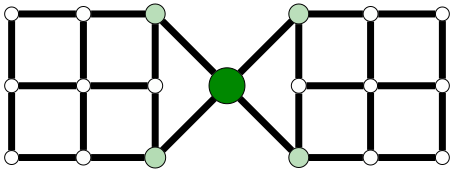

In [510]:
env = prior_envs.f2d
zs = torch.zeros(len(env.states))
for el in _490:
    if len(el['subgoals']) == 1:
        zs[el['subgoals'][0]] = -10*el['cost']
diffplan.plot_graph(prior_envs.f2d, z=zs.softmax(0))

# Fiddling with parameters

In [543]:
# comparing search algorithms...

print('dfs')
show_opt_opt_res(option_optimize(prior_envs.f2c, tqdm=tqdm, action_level_search='dfs'))
print('bfs')
show_opt_opt_res(option_optimize(prior_envs.f2c, tqdm=tqdm, action_level_search='bfs'))
print('ucs')
show_opt_opt_res(option_optimize(prior_envs.f2c, tqdm=tqdm, action_level_search='ucs'))

dfs


 [████████████████████████████████████████████████████████████] 11/11 [00:07<00:00, 0.64s/it]

[5] cost: 7.071 ± 0.0332
[4] cost: 7.071 ± 0.0286
[3] cost: 7.210 ± 0.0351
[1] cost: 7.236 ± 0.0359
[8] cost: 7.260 ± 0.0219
[6] cost: 7.264 ± 0.0316
[9] cost: 7.306 ± 0.0405
[2] cost: 7.311 ± 0.0334
[0] cost: 7.321 ± 0.0327
[7] cost: 7.381 ± 0.0268
[] cost: 7.407 ± 0.0285
bfs


 [████████████████████████████████████████████████████████████] 11/11 [00:07<00:00, 0.65s/it]

[4] cost: 7.166 ± 0.0108
[5] cost: 7.178 ± 0.0103
[1] cost: 7.266 ± 0.0114
[6] cost: 7.267 ± 0.0101
[3] cost: 7.270 ± 0.0101
[8] cost: 7.273 ± 0.0112
[9] cost: 7.402 ± 0.0103
[0] cost: 7.410 ± 0.0104
[2] cost: 7.412 ± 0.0099
[7] cost: 7.432 ± 0.0096
[] cost: 7.466 ± 0.0090
ucs


 [████████████████████████████████████████████████████████████] 11/11 [00:07<00:00, 0.60s/it]

[5] cost: 7.127 ± 0.0096
[4] cost: 7.141 ± 0.0119
[3] cost: 7.225 ± 0.0096
[8] cost: 7.227 ± 0.0104
[1] cost: 7.230 ± 0.0111
[6] cost: 7.262 ± 0.0109
[2] cost: 7.388 ± 0.0083
[0] cost: 7.390 ± 0.0084
[9] cost: 7.392 ± 0.0091
[7] cost: 7.402 ± 0.0102
[] cost: 7.462 ± 0.0098


In [541]:
# Why does BFS prefer 134568 over 0279?
show_opt_opt_res(option_optimize(prior_envs.f2c, tqdm=tqdm, visited_in_state=False, action_level_search='bfs'))
show_opt_opt_res(option_optimize(prior_envs.f2c, tqdm=tqdm, visited_in_state=False, action_level_search='bfs'))

 [████████████████████████████████████████████████████████████] 11/11 [00:07<00:00, 0.67s/it]

[4] cost: 7.312 ± 0.0099
[5] cost: 7.318 ± 0.0112
[6] cost: 7.328 ± 0.0106
[1] cost: 7.330 ± 0.0094
[3] cost: 7.333 ± 0.0101
[8] cost: 7.352 ± 0.0099
[9] cost: 7.407 ± 0.0105
[0] cost: 7.413 ± 0.0097
[7] cost: 7.424 ± 0.0097
[2] cost: 7.424 ± 0.0092
[] cost: 7.466 ± 0.0110


 [████████████████████████████████████████████████████████████] 11/11 [00:07<00:00, 0.62s/it]

[3] cost: 7.311 ± 0.0109
[8] cost: 7.320 ± 0.0110
[4] cost: 7.322 ± 0.0102
[5] cost: 7.322 ± 0.0121
[1] cost: 7.324 ± 0.0103
[6] cost: 7.327 ± 0.0111
[7] cost: 7.407 ± 0.0087
[9] cost: 7.413 ± 0.0114
[2] cost: 7.415 ± 0.0100
[0] cost: 7.429 ± 0.0100
[] cost: 7.463 ± 0.0097


In [563]:
# ok looking at old BFS
env = prior_envs.f2c
D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
d=diffplan.option_learner_enum(env, search_cost=D+BFS, num_options=1, option_planner_bfs_vec=diffplan.option_planner_hardmax, top_results=10)

{'options': (0,), 'value': -7.360000228881836}
{'options': (1,), 'value': -7.360000228881836}
{'options': (2,), 'value': -7.360000228881836}
{'options': (3,), 'value': -7.360000228881836}
{'options': (4,), 'value': -7.360000228881836}
{'options': (5,), 'value': -7.360000228881836}
{'options': (6,), 'value': -7.360000228881836}
{'options': (7,), 'value': -7.360000228881836}
{'options': (8,), 'value': -7.360000228881836}
{'options': (9,), 'value': -7.360000228881836}


0.9975559210907542

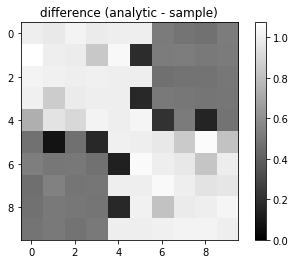

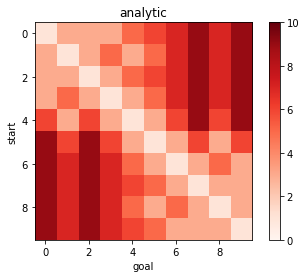

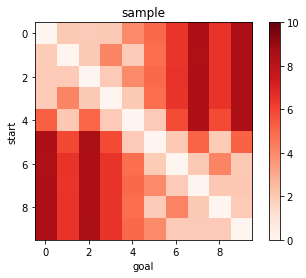

In [629]:
plt.figure()
plt.imshow(BFS-bfs_plan_costs, cmap='gray', vmin=0)
plt.title('difference (analytic - sample)')
plt.colorbar()

plt.figure()
plt.imshow(BFS, cmap='Reds', vmin=0, vmax=10)
plt.title('analytic')
plt.xlabel('goal');plt.ylabel('start')
plt.colorbar()

plt.figure()
plt.imshow(bfs_plan_costs, cmap='Reds', vmin=0, vmax=10)
plt.title('sample')
plt.xlabel('goal');plt.ylabel('start')
plt.colorbar()

np.corrcoef(BFS.flatten(), bfs_plan_costs.flatten())[0, 1]

In [630]:
def compute_bfs_matrix2(env, distance):
    def expected_bfs_cost(env, distance, termination_idx):
        # We estimate the number of nodes that would be visited
        # in breadth-first search. For a node s at distance d from goal state,
        # we know this is the number of nodes with distance<d
        # plus half the nodes with distance==d.
        bfs_cost = torch.zeros(len(env.states))
        for s in env.states:
            d = distance[s, termination_idx]
            bfs_cost[s] = (
                (distance[s]<d).sum() +
                # We add one since we always have at least one comparison.
                ((distance[s] == d).sum()-1.)/2
            )
        return bfs_cost

    BFS = torch.zeros((len(env.states), len(env.states)))
    for s_term in env.states:
        BFS[:, s_term] = expected_bfs_cost(env, distance, s_term)
    return BFS
BFS2 = compute_bfs_matrix2(env, D)

0.9975559210907542

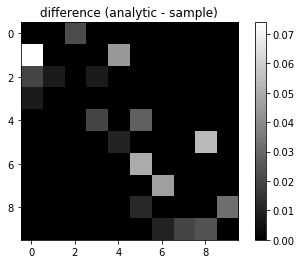

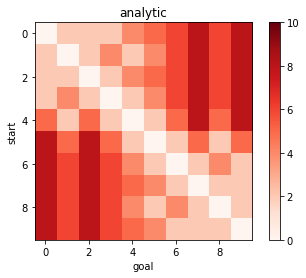

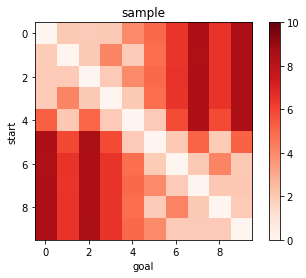

In [631]:
plt.figure()
plt.imshow(BFS2-bfs_plan_costs, cmap='gray', vmin=0)
plt.title('difference (analytic - sample)')
plt.colorbar()

plt.figure()
plt.imshow(BFS2, cmap='Reds', vmin=0, vmax=10)
plt.title('analytic')
plt.xlabel('goal');plt.ylabel('start')
plt.colorbar()

plt.figure()
plt.imshow(bfs_plan_costs, cmap='Reds', vmin=0, vmax=10)
plt.title('sample')
plt.xlabel('goal');plt.ylabel('start')
plt.colorbar()

np.corrcoef(BFS2.flatten(), bfs_plan_costs.flatten())[0, 1]

In [632]:
# how to interpret this???
def sim_bfs(env, s, g):
    res = search.bfs(env, s, g)
    return res['cost'], len(res['visited'])
bfs_distance, bfs_plan_costs = diffplan.compute_search_matrix(env, search_fn=sim_bfs, samples=500, tqdm=tqdm)
assert torch.all(bfs_distance == D)
d=diffplan.option_learner_enum(env, search_cost=bfs_distance+bfs_plan_costs, num_options=1, option_planner_bfs_vec=diffplan.option_planner_hardmax, top_results=11)

 [████████████████████████████████████████████████████████████] 10/10 [00:02<00:00, 0.17s/it]

{'options': (5,), 'value': -3.7868598222732546}
{'options': (4,), 'value': -3.7903199672698973}
{'options': (8,), 'value': -4.311039972305298}
{'options': (6,), 'value': -4.311199903488159}
{'options': (1,), 'value': -4.311459946632385}
{'options': (3,), 'value': -4.318540024757385}
{'options': (0,), 'value': -4.679400062561035}
{'options': (9,), 'value': -4.686279964447022}
{'options': (2,), 'value': -4.6863199234008786}
{'options': (7,), 'value': -4.687879824638367}
{'options': (), 'value': -6.717899990081787}


In [637]:
# replicating...
env, start, goal = prior_envs.f2c, 1, 8
subgoal = 4

search_fn = lambda *args, **kwargs: search.deterministic_search(*args, algorithm='ucs', **kwargs)
action_search_fn = search_fn # normally...
# Having this static action search fn replicates!
def action_search_fn(env, s, g, visited_init=None):
    return dict(
        visited=set(range(int(round(BFS2[s,g].item())))),
        path=[None]+[None]*int(round(D[s,g].item())),
    )
action_search_fn = lambda *args, **kw: search.dfs(*args, return_path=True, **kw)

for subgoal in env.states:
    costs = [
        search_fn(
            EnvWithSubgoalsAndVisited(env, [subgoal, goal], action_search_fn, visited_in_state=False),
            (start, frozenset()), lambda s: s[0]==goal)['cost']
        for _ in range(50)
        for start in env.states
        for goal in env.states
        #if start != goal # this changes numbers but not qualitative pattern
    ]
    print(subgoal, np.mean(costs))


0 6.5502
1 6.5174
2 6.5632
3 6.5274
4 6.468
5 6.4628
6 6.5354
7 6.5412
8 6.529
9 6.5458


Summary...
- Wrote suite of search functions with same signatures.
- Wrote environment that samples cost in planning decision, can propagate states visited.
- In what follows, I interchangeably refer to BFS & UCS. They are equivalent for problems where all actions have same cost. UCS is necessary at option-level

- BFS with history finds subgoals for small graphs.
    - DFS does too, even without history!
- BFS without history prefers 134568 over 0279. Can replicate this in old code by adapting BFS approximation to avoid counting the (sub)goal (basically, terminate search on encountering goal without adding it to `visited`).
- A mystery: estimating average cost works weirdly?

- probabilistic model of BFS - analytic ??
- schapiro graph???
- think about MCTS or AO* LAO* in planner since we have a stochastic transition function
- add option-level cost?

- OED - optimize stimuli?
    - can we find graphs with stark predictions?
    - can we get something where our predictions differ from bottleneck model?